In [1]:
%load_ext pycodestyle_magic

In [2]:
# %%pycodestyle

# Required libraries
import datetime as dt
import matplotlib.pyplot as plt

import os
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5)

In [3]:
# Constants
my_data = "../data"

# Load data

In [4]:
# Load data into Pandas dataframe
datafile = "Online Retail.xlsx"
full_path = os.path.join(my_data, datafile)
df_sales = pd.read_excel(full_path)
print(df_sales.shape)

(541909, 8)


In [5]:
# Get the full list of columns
for col_name in df_sales.axes[1]:
    print(col_name)

InvoiceNo
StockCode
Description
Quantity
InvoiceDate
UnitPrice
CustomerID
Country


In [6]:
# Sample data to get a certain knowledge of the dataframe content
df_sales.head().T

,0,1,2,3,4
InvoiceNo,536365,536365,536365,536365,536365
StockCode,85123A,71053,84406B,84029G,84029E
Description,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER,KNITTED UNION FLAG HOT WATER BOTTLE,RED WOOLLY HOTTIE WHITE HEART.
Quantity,6,6,8,6,6
InvoiceDate,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00
UnitPrice,2.55,3.39,2.75,3.39,3.39
CustomerID,17850,17850,17850,17850,17850
Country,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom


In [7]:
df_sales.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [8]:
# Check for empty values
df_sales.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We want to analyze customer behaviour. Records with empty customer IDs cannot be used. Drop them.<br>Other features look good. Missing descriptions is not an issue.

In [9]:
# Remove records with missing customer IDs
df_sales.dropna(subset=['CustomerID'], inplace=True)

In [10]:
# Check for empty values
df_sales.isnull().sum(axis=0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Good news: removing empty customer IDs also removed missing product descriptions.

In [11]:
# Look at data types
df_sales.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [12]:
# Force data types to avoid issues in further processing
df_sales['InvoiceNo'] = df_sales['InvoiceNo'].astype('str')
df_sales['StockCode'] = df_sales['StockCode'].astype('str')
df_sales['CustomerID'] = df_sales['CustomerID'].astype('int').astype('str')


In [13]:
# Check in case processing broke someting
df_sales.head().T

,0,1,2,3,4
InvoiceNo,536365,536365,536365,536365,536365
StockCode,85123A,71053,84406B,84029G,84029E
Description,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER,KNITTED UNION FLAG HOT WATER BOTTLE,RED WOOLLY HOTTIE WHITE HEART.
Quantity,6,6,8,6,6
InvoiceDate,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00
UnitPrice,2.55,3.39,2.75,3.39,3.39
CustomerID,17850,17850,17850,17850,17850
Country,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom


In [14]:
# Look at data types
df_sales.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

## Analyze each feature individually - Clean up where applicable

### InvoiceNo
This is a variable that is useful to group on to count number of items and value of each purchase. This will be the main key for the initial data transformation. How many do we have ?

In [15]:
# Print number of different invoices
nb_invoices = len(df_sales['InvoiceNo'].unique())
print('Number of different invoices: {0}'.format(nb_invoices))

Number of different invoices: 22190


### Stock code / Description
Stock code could be used to associate a newcomer into a cluster. This is to be checked later during clustering.<br>Description is useful to get an idea of the products sold, but is not interesting in data processing.

In [16]:
# Print number of different Stock Code
nb_parts = len(df_sales['StockCode'].unique())
print('Number of different stock code: {0}'.format(nb_parts))

Number of different stock code: 3684


### Quantity / UnitPrice
This feature is useful for a classification of orders (big or small orders), along with the UnitPrice (high or low value).

In [17]:
# Check the distribution of variables
df_sales[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wow ! Some quantities and prices look huge.<br>Let's look at big positive and negative quantities.

In [18]:
# Look at high quantities items
df_sales.sort_values(by='Quantity', ascending=False).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087,United Kingdom
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,2011-07-19 17:04:00,0.06,14609,United Kingdom
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749,United Kingdom
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749,United Kingdom
433788,573995,16014,SMALL CHINESE STYLE SCISSOR,3000,2011-11-02 11:24:00,0.32,16308,United Kingdom


In [19]:
df_sales.sort_values(by='Quantity', ascending=True).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838,United Kingdom
160145,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2011-04-18 13:08:00,2.10,15749,United Kingdom
160144,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2011-04-18 13:08:00,1.85,15749,United Kingdom
160143,C550456,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1930,2011-04-18 13:08:00,2.55,15749,United Kingdom
224419,C556522,22920,HERB MARKER BASIL,-1515,2011-06-13 11:21:00,0.55,16938,United Kingdom
187609,C552995,M,Manual,-1350,2011-05-12 15:19:00,0.16,18133,United Kingdom
160142,C550456,47566B,TEA TIME PARTY BUNTING,-1300,2011-04-18 13:08:00,2.55,15749,United Kingdom
390548,C570556,20971,PINK BLUE FELT CRAFT TRINKET BOX,-1296,2011-10-11 11:10:00,1.06,16029,United Kingdom


OK, some orders were mistakes and were canceled immediately after.<br>A special processing to cancel such orders will be done later.

What about huge unit prices ?

In [20]:
df_sales.sort_values(by='UnitPrice', ascending=False).head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098,United Kingdom
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom
173277,C551685,POST,POSTAGE,-1,2011-05-03 12:51:00,8142.75,16029,United Kingdom
173391,C551699,M,Manual,-1,2011-05-03 14:12:00,6930.00,16029,United Kingdom
268027,C560372,M,Manual,-1,2011-07-18 12:26:00,4287.63,17448,United Kingdom
422376,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536,France
422375,C573079,M,Manual,-2,2011-10-27 14:15:00,4161.06,12536,France
422351,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536,France
406404,C571750,M,Manual,-1,2011-10-19 11:16:00,3949.32,12744,Singapore
406406,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744,Singapore


This looks like mistakes as well, or manual adjustments for some reason.

In [21]:
df_sales[df_sales['UnitPrice'] > 1000][['StockCode', 'Description']].drop_duplicates()

,StockCode,Description
45622,M,Manual
150591,D,Discount
173277,POST,POSTAGE
467436,DOT,DOTCOM POSTAGE
467437,CRUK,CRUK Commission


In [22]:
# Real item ID start with a number, remove other ones.
df_sales = df_sales[df_sales['StockCode'].astype(str)
                    .str.slice(0, 1).str.isnumeric()]

In [23]:
df_sales.sort_values(by='UnitPrice', ascending=False).head(50)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098,United Kingdom
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098,United Kingdom
36165,C539438,22655,VINTAGE RED KITCHEN CABINET,-1,2010-12-17 15:11:00,295.0,16607,United Kingdom
82768,543253,22655,VINTAGE RED KITCHEN CABINET,1,2011-02-04 15:32:00,295.0,14842,United Kingdom
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145,United Kingdom
205759,554836,22655,VINTAGE RED KITCHEN CABINET,1,2011-05-26 16:25:00,295.0,13015,United Kingdom
171178,551393,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-04-28 12:22:00,295.0,14973,United Kingdom
87141,C543632,22655,VINTAGE RED KITCHEN CABINET,-1,2011-02-10 16:22:00,295.0,14842,United Kingdom
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.0,17406,United Kingdom
118769,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-14 11:38:00,295.0,13452,United Kingdom


Prices look much better now.

### Remove order lines that were canceled

Create keys to join lines that are identical but opposite quantities, and remove lines that cancel each other, i.e. same customer ID, same Stock Code and opposite quantities.

In [24]:
df_sales['join_key'] = (df_sales['CustomerID'] +
                        df_sales['StockCode'] +
                        abs(df_sales['Quantity']).astype('str'))

In [25]:
# Get the list of credit notes
df_credit = df_sales[df_sales['InvoiceNo'].str.startswith('C')]
df_debit = df_sales[~ df_sales['InvoiceNo'].str.startswith('C')]

In [26]:
df_credit

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,join_key
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,1531135004C1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,175482255612
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,175482198424
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,175482198324
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,175482198024
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom,175482148412
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,175482255712
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548,United Kingdom,175482255324
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897,United Kingdom,17897229606
1441,C536543,22632,HAND WARMER RED RETROSPOT,-1,2010-12-01 14:30:00,2.10,17841,United Kingdom,17841226321


In [27]:
# Find sales invoice lines which match with credit notes
df_canceled = df_debit.join(df_credit.set_index('join_key'),
                            on='join_key', how='inner', rsuffix='_cr')

In [28]:
df_canceled

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,join_key,InvoiceNo_cr,StockCode_cr,Description_cr,Quantity_cr,InvoiceDate_cr,UnitPrice_cr,CustomerID_cr,Country_cr
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,17850226326,C543611,22632,HAND WARMER RED RETROSPOT,-6,2011-02-10 14:38:00,1.85,17850,United Kingdom
47,536372,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 09:01:00,1.85,17850,United Kingdom,17850226326,C543611,22632,HAND WARMER RED RETROSPOT,-6,2011-02-10 14:38:00,1.85,17850,United Kingdom
84,536377,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 09:34:00,1.85,17850,United Kingdom,17850226326,C543611,22632,HAND WARMER RED RETROSPOT,-6,2011-02-10 14:38:00,1.85,17850,United Kingdom
315,536399,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 10:52:00,1.85,17850,United Kingdom,17850226326,C543611,22632,HAND WARMER RED RETROSPOT,-6,2011-02-10 14:38:00,1.85,17850,United Kingdom
433,536407,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 11:34:00,1.85,17850,United Kingdom,17850226326,C543611,22632,HAND WARMER RED RETROSPOT,-6,2011-02-10 14:38:00,1.85,17850,United Kingdom
3130,536601,22632,HAND WARMER RED POLKA DOT,6,2010-12-02 08:33:00,1.85,17850,United Kingdom,17850226326,C543611,22632,HAND WARMER RED RETROSPOT,-6,2011-02-10 14:38:00,1.85,17850,United Kingdom
3144,536603,22632,HAND WARMER RED POLKA DOT,6,2010-12-02 08:40:00,1.85,17850,United Kingdom,17850226326,C543611,22632,HAND WARMER RED RETROSPOT,-6,2011-02-10 14:38:00,1.85,17850,United Kingdom
3208,536610,22632,HAND WARMER RED POLKA DOT,6,2010-12-02 09:42:00,1.85,17850,United Kingdom,17850226326,C543611,22632,HAND WARMER RED RETROSPOT,-6,2011-02-10 14:38:00,1.85,17850,United Kingdom
3256,536614,22632,HAND WARMER RED POLKA DOT,6,2010-12-02 09:44:00,1.85,17850,United Kingdom,17850226326,C543611,22632,HAND WARMER RED RETROSPOT,-6,2011-02-10 14:38:00,1.85,17850,United Kingdom
3441,536629,22632,HAND WARMER RED POLKA DOT,6,2010-12-02 10:55:00,1.85,17850,United Kingdom,17850226326,C543611,22632,HAND WARMER RED RETROSPOT,-6,2011-02-10 14:38:00,1.85,17850,United Kingdom


Some customers placed several times orders with same item and same quantities which results in one credit note cancelling several invoice lines which is not correct. One cancellation line shoud cancel only one invoice line. To achieve this, remove mutiple cancellation lines.

In [29]:
# Each credit note line should cancel only one invoice line
# Some customer may have ordered the same item with same quantity
# on different invoices
df_canceled.drop_duplicates(subset=['join_key', 'InvoiceNo_cr'], inplace=True)

In [30]:
df_canceled

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,join_key,InvoiceNo_cr,StockCode_cr,Description_cr,Quantity_cr,InvoiceDate_cr,UnitPrice_cr,CustomerID_cr,Country_cr
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,17850226326,C543611,22632,HAND WARMER RED RETROSPOT,-6,2011-02-10 14:38:00,1.85,17850,United Kingdom
55,536373,21071,VINTAGE BILLBOARD DRINK ME MUG,6,2010-12-01 09:02:00,1.06,17850,United Kingdom,17850210716,C543611,21071,VINTAGE BILLBOARD DRINK ME MUG,-6,2011-02-10 14:38:00,1.06,17850,United Kingdom
57,536373,82483,WOOD 2 DRAWER CABINET WHITE FINISH,2,2010-12-01 09:02:00,4.95,17850,United Kingdom,17850824832,C543611,82483,WOOD 2 DRAWER CABINET WHITE FINISH,-2,2011-02-10 14:38:00,4.95,17850,United Kingdom
138,536381,22778,GLASS CLOCHE SMALL,3,2010-12-01 09:41:00,3.95,15311,United Kingdom,15311227783,C576561,22778,GLASS CLOCHE SMALL,-3,2011-11-15 13:22:00,3.39,15311,United Kingdom
234,536390,85099B,JUMBO BAG RED RETROSPOT,100,2010-12-01 10:19:00,1.65,17511,United Kingdom,1751185099B100,C575224,85099B,JUMBO BAG RED RETROSPOT,-100,2011-11-09 11:41:00,1.79,17511,United Kingdom
290,536396,82494L,WOODEN FRAME ANTIQUE WHITE,12,2010-12-01 10:51:00,2.55,17850,United Kingdom,1785082494L12,C543611,82494L,WOODEN FRAME ANTIQUE WHITE,-12,2011-02-10 14:38:00,2.55,17850,United Kingdom
310,536398,22114,HOT WATER BOTTLE TEA AND SYMPATHY,4,2010-12-01 10:52:00,3.95,13448,United Kingdom,13448221144,C538670,22114,HOT WATER BOTTLE TEA AND SYMPATHY,-4,2010-12-13 16:19:00,3.95,13448,United Kingdom
728,536437,21154,RED RETROSPOT OVEN GLOVE,200,2010-12-01 12:12:00,1.06,13694,United Kingdom,1369421154200,C548577,21154,RED RETROSPOT OVEN GLOVE,-200,2011-04-01 10:46:00,1.06,13694,United Kingdom
1312,536533,22680,FRENCH BLUE METAL DOOR SIGN 5,20,2010-12-01 13:31:00,1.25,16955,United Kingdom,169552268020,C538725,22680,FRENCH BLUE METAL DOOR SIGN 5,-20,2010-12-14 11:16:00,1.25,16955,United Kingdom
2051,536557,21672,WHITE SPOT RED CERAMIC DRAWER KNOB,1,2010-12-01 14:41:00,1.25,17841,United Kingdom,17841216721,C541641,21672,WHITE SPOT RED CERAMIC DRAWER KNOB,-1,2011-01-20 11:00:00,1.25,17841,United Kingdom


In [31]:
# Create a list of indexes to be removed from the sales list
canceled_indexes = pd.Series(df_canceled.index)

canceled_indexes[0:10]

0       8
1      55
2      57
3     138
4     234
5     290
6     310
7     728
8    1312
9    2051
dtype: int64

In [32]:
# Remove those indexes from the dataframe
df_sales.drop(labels=canceled_indexes, inplace=True)

# and finally remove the credit notes from the dataframe
df_sales = df_sales[~ df_sales['InvoiceNo'].str.startswith('C')]

In [33]:
df_sales[0:60]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,join_key
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,1785085123A6
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,17850710536
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,1785084406B8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,1785084029G6
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,1785084029E6
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,17850227522
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,17850217306
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,17850226336
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,130478487932
10,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2010-12-01 08:34:00,2.10,13047,United Kingdom,13047227456


In [34]:
df_sales.shape

(393352, 9)

In [35]:
# Check again the distribution of variables
df_sales[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,393352.000000,393352.000000
mean,12.573303,2.848352
std,46.505443,4.097128
min,1.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,1.850000
75%,12.000000,3.750000
max,12540.000000,649.500000


### InvoiceDate
This feature is useful to calculate the frequency of purchase of a customer, and since how long he didn't make any purchase.

In [36]:
print('Earliest invoice date: {0}'.format(df_sales['InvoiceDate'].min()))
print('Latest invoice date: {0}'.format(df_sales['InvoiceDate'].max()))

Earliest invoice date: 2010-12-01 08:26:00
Latest invoice date: 2011-12-09 12:50:00


### CustomerID
Of course a key feature as we want to create classes of customers.

In [37]:
# Print number of different Stock Code
nb_customers = len(df_sales['CustomerID'].unique())
print('Total number of customers: {0}'.format(nb_customers))

Total number of customers: 4323


### Country
Knowing that the resell company from which this dataset comes from is UK based, get an understanding of what sales are done outside UK. Could be used in the classification as customer behaviour could be different depending on the country. However this has to be proven.

In [38]:
# Number of invoices per country
(df_sales[['InvoiceNo', 'Country']].drop_duplicates()
 .groupby(['Country']).count()
 .reset_index().sort_values('InvoiceNo', ascending=False))

,Country,InvoiceNo
35,United Kingdom,16477
14,Germany,441
13,France,378
10,EIRE,253
3,Belgium,98
23,Netherlands,94
30,Spain,86
0,Australia,53
26,Portugal,49
32,Switzerland,45


In [39]:
# Number of unique customers per country
(df_sales[['CustomerID', 'Country']].drop_duplicates()
 .groupby(['Country']).count()
 .reset_index().sort_values('CustomerID', ascending=False))

,Country,CustomerID
35,United Kingdom,3908
14,Germany,94
13,France,87
30,Spain,29
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,14
12,Finland,12
1,Austria,11


In [40]:
# Do some customers order for several countries ?
customer_country = (df_sales[['CustomerID', 'Country']]
                    .drop_duplicates().groupby(['CustomerID']).count())
customer_country[customer_country['Country'] > 1]

,Country
CustomerID,
12370,2
12394,2
12417,2
12422,2
12429,2
12431,2
12455,2
12457,2


Finally the country was not taken into account for segmentation.

# Create features to qualify customers

### Number of orders per year

In [41]:
# Calculate number of invoices per year. Of course, this cannot be used for
# new customers but is still useful to classify existing ones.
invoice_number = (df_sales[['CustomerID', 'InvoiceNo']].drop_duplicates()
                  .groupby(by=['CustomerID']).count().reset_index())
invoice_number.rename(index=str, columns={'InvoiceNo': 'InvoiceNumberYear'},
                      inplace=True)
invoice_number.shape

(4323, 2)

In [42]:
invoice_number.sort_values(by='InvoiceNumberYear', ascending=False)

,CustomerID,InvoiceNumberYear
322,12748,204
1872,14911,195
3998,17841,124
558,13089,94
2169,15311,90
1655,14606,89
477,12971,85
1683,14646,73
791,13408,62
2693,16029,60


There are some customers ordering many times, and also, some of them order very large quantities. This site may be a master reseller for professionals or distributors, along with some individual customers. Good to know for segmentation.

### Last invoice date

In [43]:
# Calculate last invoice date
last_invoice_date = (df_sales[['CustomerID', 'InvoiceDate']]
                     .groupby(by=['CustomerID']).max().reset_index())
# Replace by year/month
last_invoice_date['InvoiceDate'] = (last_invoice_date['InvoiceDate'].dt.year*100
                                    + last_invoice_date['InvoiceDate'].dt.month)

last_invoice_date.rename(columns={'InvoiceDate': 'LastInvoiceMonth'},
                         index=str, inplace=True)

last_invoice_date.shape

(4323, 2)

In [44]:
# Calculate number of months between last invoice and "today"
# "today" is defined as the last month of the dataset.

# Replace december of year before by a value that allows substraction
last_invoice_date['LastInvoiceMonth'] = (last_invoice_date['LastInvoiceMonth']
                                         .replace({201012: 201100}))

# Actual calculation
max_date = last_invoice_date['LastInvoiceMonth'].max()
last_invoice_date['LastInvoiceMonthNb'] = (max_date - 
                                           last_invoice_date['LastInvoiceMonth'])

In [45]:
last_invoice_date.groupby('LastInvoiceMonthNb').count()

,CustomerID,LastInvoiceMonth
LastInvoiceMonthNb,,
0,612,612
1,1289,1289
2,653,653
3,403,403
4,215,215
5,177,177
6,182,182
7,166,166
8,135,135


### Number of line items per invoice per customer

In [46]:
# Count number of lines on each invoice
invoice_lines = (df_sales[['CustomerID', 'InvoiceNo', 'StockCode']]
                 .groupby(by=['CustomerID', 'InvoiceNo']).count().reset_index())

# Calculate mean value per customer of number of lines on ivoice
invoice_lines_mean = invoice_lines.groupby(by=['CustomerID']).mean().reset_index()
invoice_lines_mean.rename(index=str, columns={'StockCode': 'MeanLinesPerInvoice'},
                          inplace=True)
invoice_lines_mean.shape

(4323, 2)

In [47]:
invoice_lines_mean[invoice_lines_mean['MeanLinesPerInvoice'] > 200]


,CustomerID,MeanLinesPerInvoice
26,12378,219.000000
150,12536,251.000000
1284,14096,299.705882
3390,16984,201.500000


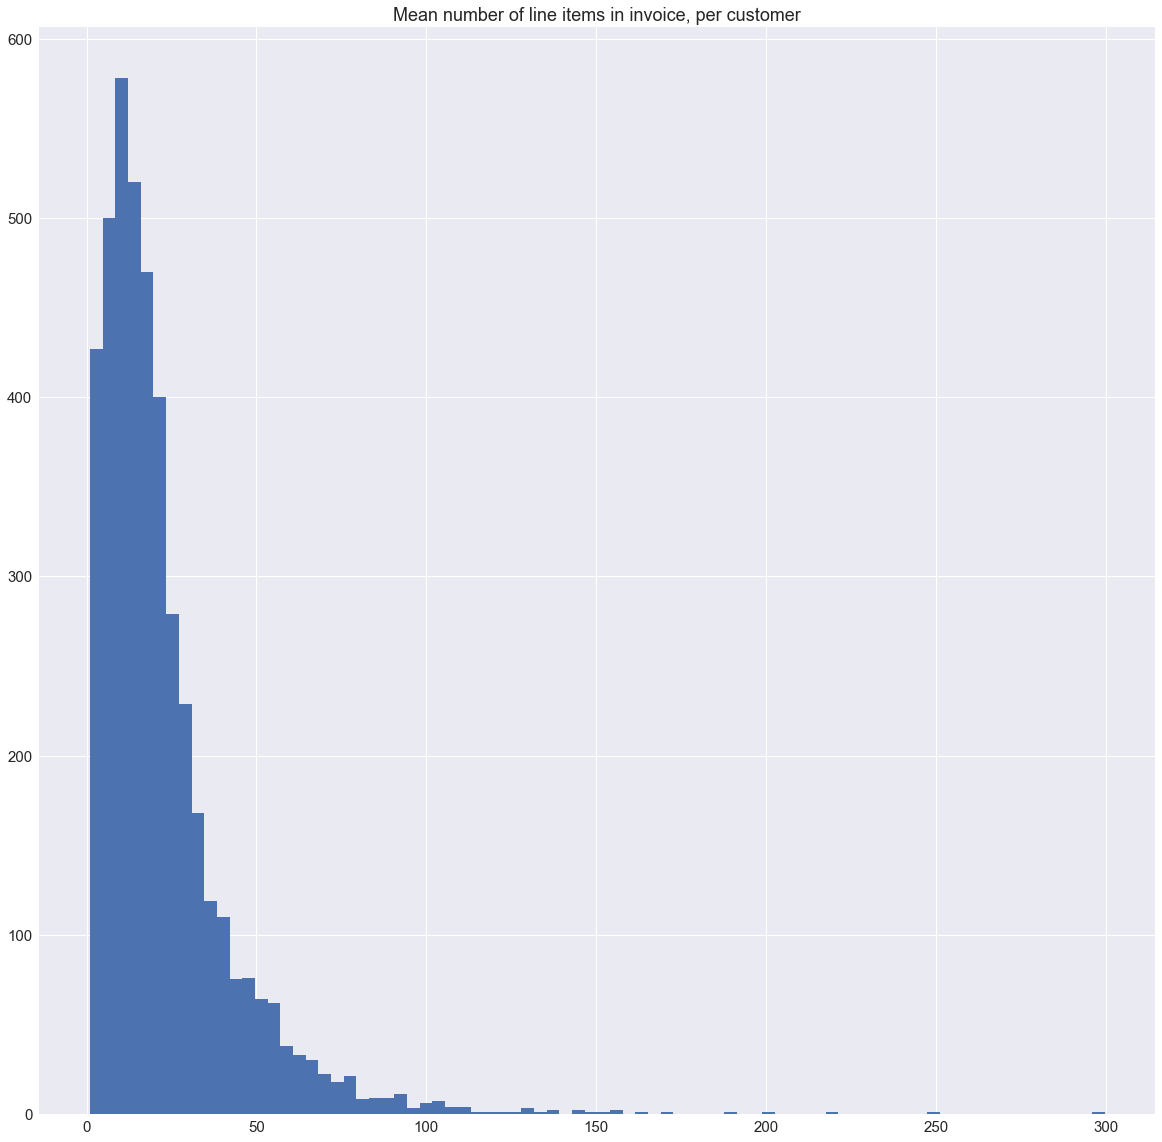

In [48]:
# Check final distribution
fig, ax = plt.subplots(figsize=(20, 20))
plt.hist(invoice_lines_mean['MeanLinesPerInvoice'].dropna(), bins=80)
plt.title('Mean number of line items in invoice, per customer', fontsize=18)
plt.show()

### Sum of quantities per order

In [49]:
# Calculate total number of quantities for each invoice
invoice_items = (df_sales[['CustomerID', 'InvoiceNo', 'Quantity']]
                 .groupby(by=['CustomerID', 'InvoiceNo']).sum().reset_index())

# Calculate mean value per customer of number of quantity of items per ivoice
invoice_items_mean = invoice_items.groupby(by=['CustomerID']).mean().reset_index()
invoice_items_mean.rename(index=str, columns={'Quantity': 'MeanQuantityPerInvoice'},
                          inplace=True)
invoice_items_mean.shape

(4323, 2)

In [50]:
invoice_items_mean[invoice_items_mean['MeanQuantityPerInvoice'] > 500]

,CustomerID,MeanQuantityPerInvoice
1,12348,583.000000
2,12349,630.000000
6,12354,530.000000
8,12356,524.333333
9,12357,2708.000000
19,12370,587.500000
20,12371,582.000000
26,12378,2529.000000
39,12397,625.000000
40,12398,1389.000000


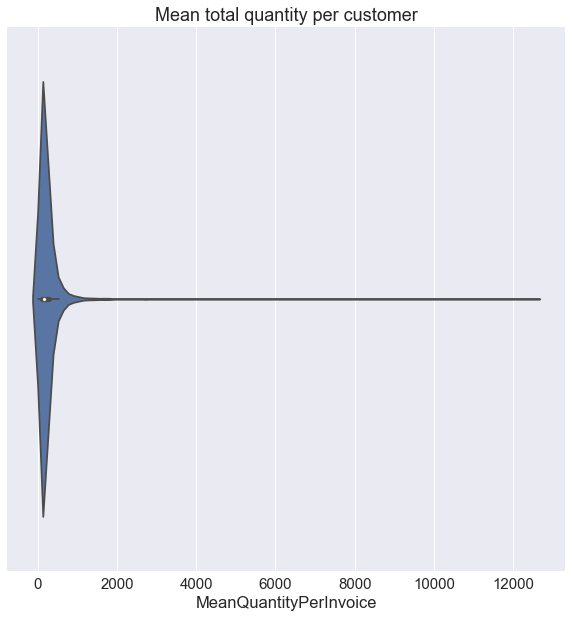

In [51]:
# Check final distribution
fig, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(invoice_items_mean['MeanQuantityPerInvoice'])
plt.title('Mean total quantity per customer', fontsize=18)
plt.show()

### Mean amount of invoice, per customer

In [52]:
# Calculate total invoice amount for each invoice
df_sales['TotalPrice'] = df_sales['Quantity'] * df_sales['UnitPrice']
invoice_amount = (df_sales[['CustomerID', 'InvoiceNo', 'TotalPrice']]
                  .groupby(by=['CustomerID', 'InvoiceNo']).sum().reset_index())
invoice_amount.shape


(18282, 3)

In [53]:
invoice_amount

,CustomerID,InvoiceNo,TotalPrice
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91
5,12347,573511,1294.32
6,12347,581180,224.82
7,12348,539318,652.80
8,12348,541998,187.44
9,12348,548955,327.00


In [54]:
# Calculate mean monetary value for invoice, per customer
invoice_amount_mean = (invoice_amount.groupby(by=['CustomerID'])
                       .mean().reset_index())
invoice_amount_mean.rename(columns={'TotalPrice': 'MeanAmountPerInvoice'},
                           index=str, inplace=True)
invoice_amount_mean.shape

(4323, 2)

In [55]:
invoice_amount_mean

,CustomerID,MeanAmountPerInvoice
0,12347,615.714286
1,12348,359.310000
2,12349,1457.550000
3,12350,294.400000
4,12352,180.772857
5,12353,89.000000
6,12354,1079.400000
7,12355,459.400000
8,12356,829.143333
9,12357,6207.670000


### Total amount spent

In [56]:
# Calculate mean monetary value for invoice, per customer
total_amount_spent = (invoice_amount.groupby(by=['CustomerID'])
                      .sum().reset_index())
total_amount_spent.rename(columns={'TotalPrice': 'TotalAmountSpent'},
                          index=str, inplace=True)
total_amount_spent.shape

(4323, 2)

### Create customer dataframe

In [57]:
df_customers = invoice_number.join(last_invoice_date.set_index('CustomerID'),
                                   on='CustomerID')
df_customers = df_customers.join(invoice_lines_mean.set_index('CustomerID'),
                                 on='CustomerID')
df_customers = df_customers.join(invoice_items_mean.set_index('CustomerID'),
                                 on='CustomerID')
df_customers = df_customers.join(invoice_amount_mean.set_index('CustomerID'),
                                 on='CustomerID')
df_customers = df_customers.join(total_amount_spent.set_index('CustomerID'),
                                 on='CustomerID')

In [58]:
df_customers

,CustomerID,InvoiceNumberYear,LastInvoiceMonth,LastInvoiceMonthNb,MeanLinesPerInvoice,MeanQuantityPerInvoice,MeanAmountPerInvoice,TotalAmountSpent
0,12347,7,201112,0,26.000000,351.142857,615.714286,4310.00
1,12348,4,201109,3,6.750000,583.000000,359.310000,1437.24
2,12349,1,201111,1,72.000000,630.000000,1457.550000,1457.55
3,12350,1,201102,10,16.000000,196.000000,294.400000,294.40
4,12352,7,201111,1,10.000000,66.142857,180.772857,1265.41
5,12353,1,201105,7,4.000000,20.000000,89.000000,89.00
6,12354,1,201104,8,58.000000,530.000000,1079.400000,1079.40
7,12355,1,201105,7,13.000000,240.000000,459.400000,459.40
8,12356,3,201111,1,19.333333,524.333333,829.143333,2487.43
9,12357,1,201111,1,131.000000,2708.000000,6207.670000,6207.67


### Analyze customer dataframe

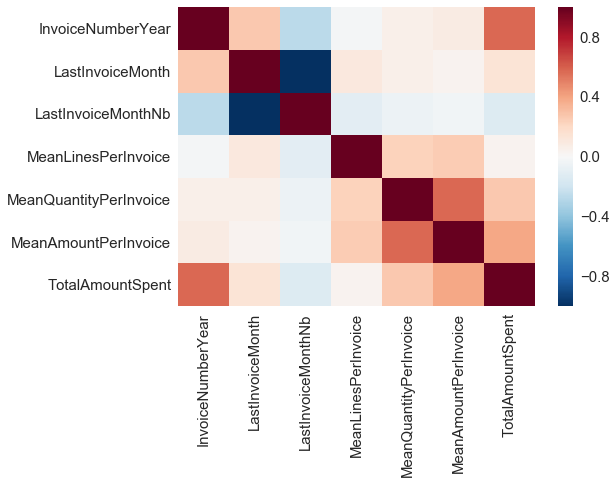

In [59]:
corr = df_customers.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

Of course, mean quantity is pretty much correlated (0.57) with mean amount, however, mean lines is not so much correlated (0.25).<br>
Let's drop mean quantity and keep the other ones.

## Create customer segmentations

The customer database with the new created features is segmented using several approaches.<br>First approach is to use the whole set of customers and do a k-means clustering. Later, to train and evaluate the classification algorythms, the whole dataset will be split in train and test sets. However, the data from the test sets have been used to create the k-means segmentation which may lead to data leakage. To qualfy this possible data leakage, other approaches will be used as well.

### 1. Global segmentation

The first approach is to consider all customers and run a k-means clustering.

In [60]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [61]:
# Selection of features to do the clustering
# Keeping only features that are available for new customers
# having placed only one order
df_num = df_customers[['InvoiceNumberYear', 'LastInvoiceMonthNb',
                       'MeanLinesPerInvoice', 'MeanAmountPerInvoice',
                       'TotalAmountSpent']]

# Normalize dataframe
df_norm = scale(df_num)

In [62]:
# Search silhouette coefficients depending on number of clusters
list_values = range(2, 50)
d = {'clusters': list(list_values), 'Silhouette': list(list_values)}
df_cluster = pd.DataFrame(d)

max_value = 0
max_index = 0

for n_cluster in list_values:
    # Run K-means algorythm
    kmeans = KMeans(n_clusters=n_cluster)
    kmeans.fit(df_norm)
    sil_value = round(silhouette_score(df_norm, kmeans.labels_), 3)
    # print(str(n_cluster) + " " + str(sil_value))
    df_cluster.loc[n_cluster-2, 'Silhouette'] = sil_value
    if sil_value > max_value:
        max_value = sil_value
        max_index = n_cluster

print("Max value " + str(max_value) + " for " + str(max_index) + " clusters")

Max value 0.885 for 2 clusters


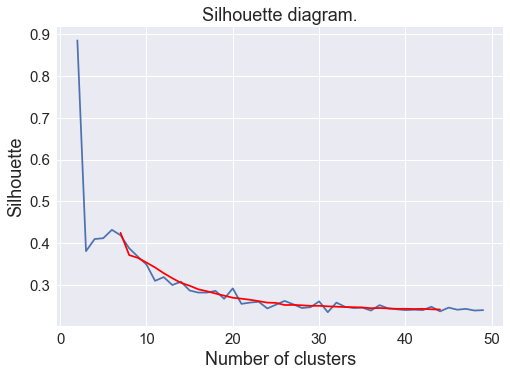

In [63]:
# Variation of silhouette coeff depending on number of clusters
plt.plot(df_cluster['clusters'], df_cluster['Silhouette'])
plt.xlabel('Number of clusters', fontsize=18)
plt.ylabel('Silhouette', fontsize=18)
plt.title('Silhouette diagram.')
sil_means = df_cluster['Silhouette'].rolling(window=11, center=True).mean()
plt.plot(df_cluster['clusters'], sil_means, 'red')
plt.show()

This peculiar result probably shows that there is a group of outliers to be separated from the rest.

In [64]:
# Go with number of clusters maximizing the silhouette score
n_cluster = max_index
n_cluster = 10
# Run K-means algorythm
kmeans = KMeans(n_clusters=n_cluster)
kmeans.fit(df_norm)
# add cluster number to each customer
df_customers['cluster_k'] = kmeans.labels_
sil_value = round(silhouette_score(df_norm, kmeans.labels_), 3)
print('Silhouette score for this clustering with {1} clusters {0}'
      .format(sil_value, n_cluster))

Silhouette score for this clustering with 10 clusters 0.344


In [65]:
# Get some key indicators per cluster
cluster_info_k = (df_customers[['CustomerID', 'cluster_k']]
                  .groupby(by='cluster_k').count())
cluster_info_k = round(cluster_info_k
                       .join(df_customers.groupby(by='cluster_k').mean(),
                             rsuffix='_mean'), 1)
cluster_info_k = (cluster_info_k
                  .rename(index=str, columns={'CustomerID': 'CustomerNumber'})
                  .reset_index())

cluster_info_k

,cluster_k,CustomerNumber,InvoiceNumberYear,LastInvoiceMonth,LastInvoiceMonthNb,MeanLinesPerInvoice,MeanQuantityPerInvoice,MeanAmountPerInvoice,TotalAmountSpent
0,0,886,3.4,201110.3,1.7,36.5,300.7,483.8,1586.4
1,1,925,1.5,201103.3,8.7,15.6,165.0,286.6,431.0
2,2,3,59.3,201112.0,0.0,14.3,1767.9,4121.2,242734.3
3,3,18,59.9,201111.8,0.2,16.5,731.0,1095.5,51240.0
4,4,1981,3.4,201110.2,1.8,12.8,178.6,268.8,935.5
5,5,17,4.9,201110.1,1.9,103.0,2359.7,4110.0,20421.7
6,6,276,17.8,201111.5,0.5,17.6,259.5,445.7,7602.8
7,7,212,2.7,201109.4,2.6,80.3,417.4,671.2,1798.9
8,8,3,1.7,201105.0,7.0,23.7,3156.5,13858.8,24603.9
9,9,2,199.5,201112.0,0.0,25.2,257.5,408.0,80229.1


In [66]:
# Select the clusters having the lowest number of members to merge them
cluster_stats = (cluster_info_k
                 .reset_index()
                 .sort_values('CustomerNumber'))
df_customers['cluster_k'] = df_customers['cluster_k'].astype(int)
outliers = cluster_stats.loc[cluster_stats['CustomerNumber'] < 100, ['cluster_k']]

grouping_cluster = outliers.iloc[0, ].values

for cluster in outliers['cluster_k'].values:
    df_customers.loc[df_customers['cluster_k'] == int(cluster),
                     ['cluster_k']] = grouping_cluster

In [67]:
# Get some key indicators per cluster
cluster_info_k = (df_customers[['CustomerID', 'cluster_k']]
                  .groupby(by='cluster_k').count())
cluster_info_k = round(cluster_info_k
                       .join(df_customers.groupby(by='cluster_k').mean(),
                             rsuffix='_mean'), 1)
cluster_info_k = (cluster_info_k
                  .rename(index=str, columns={'CustomerID': 'CustomerNumber'})
                  .reset_index())

cluster_info_k

,cluster_k,CustomerNumber,InvoiceNumberYear,LastInvoiceMonth,LastInvoiceMonthNb,MeanLinesPerInvoice,MeanQuantityPerInvoice,MeanAmountPerInvoice,TotalAmountSpent
0,0,886,3.4,201110.3,1.7,36.5,300.7,483.8,1586.4
1,1,925,1.5,201103.3,8.7,15.6,165.0,286.6,431.0
2,4,1981,3.4,201110.2,1.8,12.8,178.6,268.8,935.5
3,6,276,17.8,201111.5,0.5,17.6,259.5,445.7,7602.8
4,7,212,2.7,201109.4,2.6,80.3,417.4,671.2,1798.9
5,9,43,40.5,201110.7,1.3,51.4,1594.4,3356.9,51906.1


Display the clusters in a t-SNE scatter plot

In [68]:
from sklearn import manifold

# Run t-SNE dimension reduction and plot it
p = 50
tsne = manifold.TSNE(n_components=2, perplexity=p, n_iter=5000, init='pca')
df_tsne = tsne.fit_transform(df_norm)


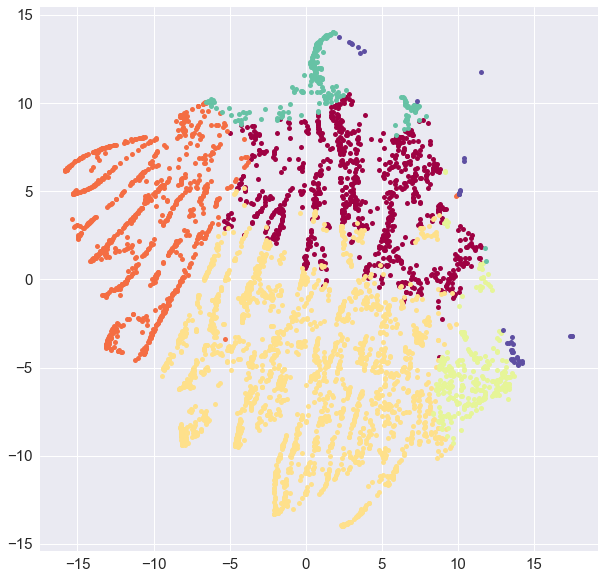

In [69]:
# Get colors plot accordding on the k-means clustering
labels = df_customers['cluster_k'].values

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = df_tsne[class_member_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
            markersize=5)

plt.show()

In [70]:
# Save file to CSV
datafile = "datazon_customer_data.csv"
full_path = os.path.join(my_data, datafile)
df_customers.to_csv(full_path, encoding="utf-8", index=False)

In [71]:
# Remove labels column for next clusterings
df_customers.drop('cluster_k', axis=1, inplace=True)

## Try several other split methods

Several methods will be used. A function is defined to be applied on each case.

In [72]:
def classify_customers(X_train, X_test, version):

    # Scale the dataset
    std_scale = StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test)

    # Run K-means algorythm
    n_cluster = 8
    kmeans = KMeans(n_clusters=n_cluster)
    kmeans.fit(X_train_std)

    sil_value = round(silhouette_score(X_train_std, kmeans.labels_), 3)
    print('Silhouette score for this clustering with {1} clusters {0}'
          .format(sil_value, n_cluster))

    # Apply labels on the train set
    df_train_clusters = pd.DataFrame(kmeans.labels_, X_train.index,
                                     columns=['cluster_k'])

    df_train_clusters = df_train_clusters.join(df_customers)

    # predict labels for customers in the test set
    test_labels = kmeans.predict(X_test_std)

    df_test_clusters = pd.DataFrame(test_labels, X_test.index,
                                    columns=['cluster_k'])

    df_test_clusters = df_test_clusters.join(df_customers)

    # Merge small clusters into one single cluster
    cluster_info_k = (df_train_clusters[['CustomerID', 'cluster_k']]
                      .groupby(by='cluster_k').count())
    cluster_info_k = (cluster_info_k
                      .rename(columns={'CustomerID': 'CustomerNumber'},
                              index=str)
                      .reset_index())

    # Select the clusters having the lowest number of members to merge them
    cluster_stats = cluster_info_k.reset_index().sort_values('CustomerNumber')
    df_train_clusters['cluster_k'] = df_train_clusters['cluster_k'].astype(int)
    outliers = (cluster_stats.loc[cluster_stats['CustomerNumber'] < 100,
                                  ['cluster_k']])

    if len(outliers) > 0:
        # Take the first cluster ID as the one to merge the others into.
        grouping_cluster = outliers.iloc[0, ].values

        for cluster in outliers['cluster_k'].values:
            df_train_clusters.loc[df_train_clusters['cluster_k'] == int(cluster),
                                  ['cluster_k']] = grouping_cluster
            df_test_clusters.loc[df_test_clusters['cluster_k'] == int(cluster),
                                 ['cluster_k']] = grouping_cluster
    
    print("Number of final clusters: {0}"
          .format(df_train_clusters['cluster_k'].nunique()))
    
    # Save train set to CSV
    datafile = "datazon_customer_data_{0}_train.csv".format(version)
    full_path = os.path.join(my_data, datafile)
    df_train_clusters.to_csv(full_path, encoding="utf-8", index=False)

    # Save test set to CSV
    datafile = "datazon_customer_data_{0}_test.csv".format(version)
    full_path = os.path.join(my_data, datafile)
    df_test_clusters.to_csv(full_path, encoding="utf-8", index=False)

    # Run t-SNE dimension reduction and plot it
    p = 50
    tsne = manifold.TSNE(n_components=2, perplexity=p, n_iter=1000, init='pca')
    df_tsne = tsne.fit_transform(X_train_std)

    # Get colors plot accordding on the k-means clustering
    labels = df_train_clusters['cluster_k'].values

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = df_tsne[class_member_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markersize=5)

    plt.show()

Using the complete customer set to train the K-means clustering may result in data leakage because the algorythm have knowledge of the future test set through the initial classification. The approach below first splits the data in train and test, does the clustering only on train set, and the labels the test set with the trained model.

### 2. Split train and test sets and run k-means on train set only

Silhouette score for this clustering with 8 clusters 0.36
Number of final clusters: 5


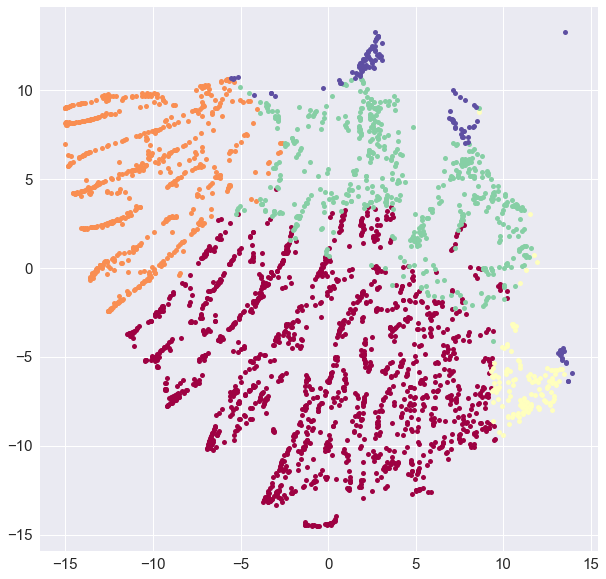

In [73]:
from sklearn.model_selection import train_test_split
# Separate features and labels
X = df_customers[['InvoiceNumberYear', 'LastInvoiceMonthNb',
                  'MeanLinesPerInvoice', 'MeanAmountPerInvoice',
                  'TotalAmountSpent']]


# Random sampling for train and test set
X_train, X_test = train_test_split(X, test_size=0.33)

classify_customers(X_train, X_test, 2)

### 3. Create train set with time-based orders

Here, the train set is composed by customers having not ordered during the last 4 months of the year, and the test set is the complement.

Silhouette score for this clustering with 8 clusters 0.334
Number of final clusters: 4


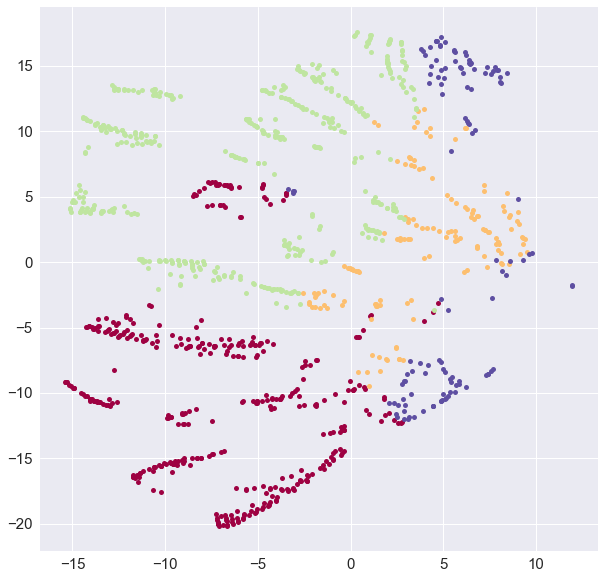

In [74]:
X_train = df_customers.loc[df_customers['LastInvoiceMonthNb'] > 4,
                           ['InvoiceNumberYear', 'LastInvoiceMonthNb',
                            'MeanLinesPerInvoice', 'MeanAmountPerInvoice',
                            'TotalAmountSpent']]

X_test = df_customers.loc[df_customers['LastInvoiceMonthNb'] <= 4,
                          ['InvoiceNumberYear', 'LastInvoiceMonthNb',
                           'MeanLinesPerInvoice', 'MeanAmountPerInvoice',
                           'TotalAmountSpent']]

classify_customers(X_train, X_test, 3)

### 4. Create train set with low expense customers

Here the train set is the subset of customers composed of the 3 first quartiles of total expense, and the test set is the fourth quartile. Again, clustering is traine on train set only and the labels of the test set are predicted through the K-means algorithm.

Silhouette score for this clustering with 8 clusters 0.272
Number of final clusters: 8


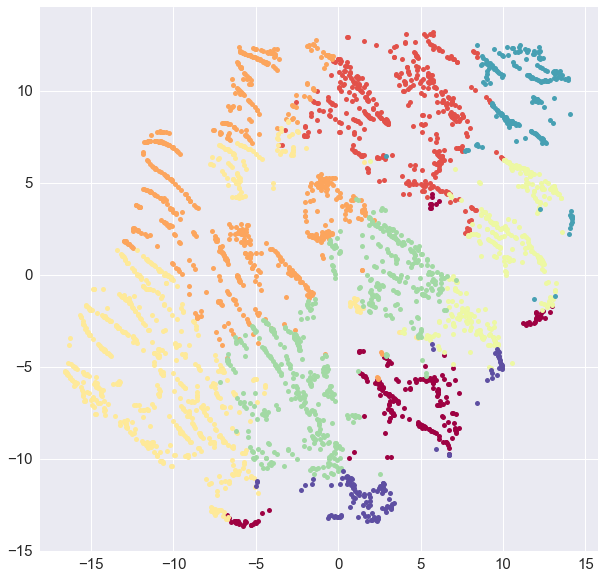

In [75]:
TotalAmountSpentQ3 = df_customers['TotalAmountSpent'].quantile(.75)

X_train = df_customers.loc[df_customers['TotalAmountSpent'] < TotalAmountSpentQ3,
                           ['InvoiceNumberYear', 'LastInvoiceMonthNb',
                            'MeanLinesPerInvoice', 'MeanAmountPerInvoice',
                            'TotalAmountSpent']]

X_test = df_customers.loc[df_customers['TotalAmountSpent'] >= TotalAmountSpentQ3,
                          ['InvoiceNumberYear', 'LastInvoiceMonthNb',
                           'MeanLinesPerInvoice', 'MeanAmountPerInvoice',
                           'TotalAmountSpent']]

classify_customers(X_train, X_test, 4)